# Detecting Political Bias with an RNN

## Setup

In [1]:
import pathlib
import os
import math, random

import numpy as np
import tensorflow as tf
from tensorflow.keras import utils

from tensorflow.keras import preprocessing

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # Import the stop word list

import re

tf.__version__


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muhammadrafay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'2.3.0'

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])

## Setup input pipeline




In [3]:
cwd = os.getcwd()
train_dir = pathlib.Path(cwd).parent.parent/'Data'/'Train'
test_dir = pathlib.Path(cwd).parent.parent/'Data'/'Test'

print(train_dir)
print(test_dir)


/Users/muhammadrafay/Desktop/UIUC/Fall2020/CS410_Text_Information_Systems/Final Project/Political_Bias_NLP/Data/Train
/Users/muhammadrafay/Desktop/UIUC/Fall2020/CS410_Text_Information_Systems/Final Project/Political_Bias_NLP/Data/Test


In [539]:

def title_cleaning( raw_title ):
    # 1. 
    review_text = raw_title
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [540]:

train_split = 0.8


cwd = os.getcwd()

labeled_left_dir = pathlib.Path.joinpath(dataset_dir.parent, "Labeled_Data/Left/Left.txt")
labeled_right_dir = pathlib.Path.joinpath(dataset_dir.parent, "Labeled_Data/Right/Right.txt")

Train_left_dir = pathlib.Path.joinpath(dataset_dir.parent, "Train/Left")
Train_right_dir = pathlib.Path.joinpath(dataset_dir.parent, "Train/Right")

Test_left_dir = pathlib.Path.joinpath(dataset_dir.parent, "Test/Left")
Test_right_dir = pathlib.Path.joinpath(dataset_dir.parent, "Test/Right")

labeled_dirs = [labeled_left_dir, labeled_right_dir]
train_dirs = [Train_left_dir, Train_right_dir]
test_dirs = [Test_left_dir, Test_right_dir]


for dr in range(2):

    f = open(labeled_dirs[dr], "r")
    lines = f.readlines()

    
    arr = np.arange(0,len(lines))
    np.random.shuffle(arr)
    
    nTrain = math.floor(len(lines)*train_split)
    
    
    c = 0  
    for i in range(nTrain):
        c = c + 1                                   
        file_path = pathlib.Path.joinpath(train_dirs[dr], str(c) + '.txt')                                    
        nf = open(file_path, "w")
        nf.write(title_cleaning(lines[arr[i]]))
    
    c = 0
    for i in range(nTrain, len(lines)):
        c = c + 1                                   
        file_path = pathlib.Path.joinpath(test_dirs[dr], str(c) + '.txt')                                    
        nf = open(file_path, "w")
        nf.write(lines[arr[i]])




In [541]:
batch_size = 16
seed = 42


raw_train_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    seed = seed)

raw_test_ds = preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    seed=seed)


Found 3095 files belonging to 2 classes.
Found 689 files belonging to 2 classes.


In [542]:
for text_batch, label_batch in raw_train_ds.take(2):
    for i in range(10):
        print("Question: ", text_batch.numpy()[i][:100], '...')
        print("Label:", label_batch.numpy()[i])

Question:  b'democrats hope year old win republican house seat georgia' ...
Label: 0
Question:  b'education chief pick betsy devos primary interloper trump represent republican party breitbart' ...
Label: 1
Question:  b'cruz pitch republican jewish coalition trump nomination bloodbath walter mondale proportions breitba' ...
Label: 0
Question:  b'washington post democrats panicking' ...
Label: 0
Question:  b'republicans gain governorships north carolina air' ...
Label: 1
Question:  b'trump supporter shot democratic congressmen' ...
Label: 1
Question:  b'simple reason black early voting worry democrats much' ...
Label: 0
Question:  b'democrats grind senate work halt comey firing' ...
Label: 0
Question:  b'new worry clinton trump struggles may depress democratic voter turnout' ...
Label: 1
Question:  b'exclusive regnery anti trump democrats best allies senate republicans breitbart' ...
Label: 0
Question:  b'exclusive pat buchanan donald trump rise rejection quarter century bush republican

In [543]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Left
Label 1 corresponds to Right


Initially this returns a dataset of (text, label pairs):

In [544]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'democrats approve platform draft sanders imprint'
 b'body blow investigation democrats slam gop investigator disclosure trump wiretap claims'
 b'democrats must avoid fighting back trump'
 b'exclusive pat buchanan donald trump rise rejection quarter century bush republicanism breitbart'
 b'single republican delegate bound donald trump'
 b'early sign trump organized big democratic advantage nevada voting'
 b'trump tucker carlson know counties voted lose republican health plan'
 b'san diego paper endorses clinton st democrat years'
 b'obama made anti trump republicans jealous'
 b'hackers release phone numbers house democrats'
 b'bernie sanders defends campaigning anti abortion rights democrat'
 b'new worry clinton trump struggles may depress democratic voter turnout'
 b'washington post chief correspondent trolls republicans turn president trump'
 b'washington post democrats panicking'
 b'camille paglia predicts trump reelection democrats overplayed hand'
 b'cbo delivered huge bl

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [545]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [546]:
train_dataset = raw_train_ds
test_dataset =  raw_test_ds
#train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
#test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [547]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'biden ronald reagan could win republican primary today'
 b'republicans control presidency senate house'
 b'moderator democrat debate live mic oh god breitbart']

labels:  [0 1 1]


## Create the text encoder

 The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. 

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [548]:
VOCAB_SIZE = 2300
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [549]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'republicans', 'democrats', 'trump', 'republican',
       'breitbart', 'democratic', 'party', 'house', 'clinton', 'donald',
       'obamacare', 'democrat', 'senate', 'bill', 'health', 'hillary',
       'obama', 'care'], dtype='<U15')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [550]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 262,    1,  762,   42,   30,    5,   38,  519,    0,    0],
       [   2,   64,  270,   14,    9,    0,    0,    0,    0,    0],
       [1889,   13,   31,  480,    1, 1282, 2052,    6,    0,    0]])

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [551]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'biden ronald reagan could win republican primary today'
Round-trip:  biden [UNK] reagan could win republican primary today  

Original:  b'republicans control presidency senate house'
Round-trip:  republicans control presidency senate house     

Original:  b'moderator democrat debate live mic oh god breitbart'
Round-trip:  moderator democrat debate live [UNK] oh god breitbart  



## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [552]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [553]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [554]:
# predict on a sample text without padding.

sample_text = ('Republicans lack agreement on Obamacare ahead of Trump speech')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.01122385]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [555]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.01122384]


Compile the Keras model to configure the training process:

In [556]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [557]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, #testdataset required
                    validation_steps=10)

Epoch 1/10
194/194 [==============================] - 10s 51ms/step - loss: 0.6914 - accuracy: 0.5205 - val_loss: 0.6897 - val_accuracy: 0.5938
Epoch 2/10
194/194 [==============================] - 2s 11ms/step - loss: 0.6749 - accuracy: 0.5215 - val_loss: 0.6763 - val_accuracy: 0.6375
Epoch 3/10
194/194 [==============================] - 2s 11ms/step - loss: 0.5907 - accuracy: 0.6475 - val_loss: 0.9386 - val_accuracy: 0.6000
Epoch 4/10
194/194 [==============================] - 2s 11ms/step - loss: 0.4992 - accuracy: 0.7283 - val_loss: 0.8458 - val_accuracy: 0.6438
Epoch 5/10
194/194 [==============================] - 2s 11ms/step - loss: 0.4132 - accuracy: 0.7968 - val_loss: 1.0127 - val_accuracy: 0.6438
Epoch 6/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3535 - accuracy: 0.8346 - val_loss: 1.3206 - val_accuracy: 0.5562
Epoch 7/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3123 - accuracy: 0.8588 - val_loss: 1.7581 - val_accuracy: 0.550

In [558]:
test_loss, test_acc = model.evaluate(test_dataset) # test_dataset required

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

44/44 [==============================] - 0s 7ms/step - loss: 1.9975 - accuracy: 0.6023
Test Loss: 1.9975488185882568
Test Accuracy: 0.6023222208023071


(0.0, 2.7229900650680063)

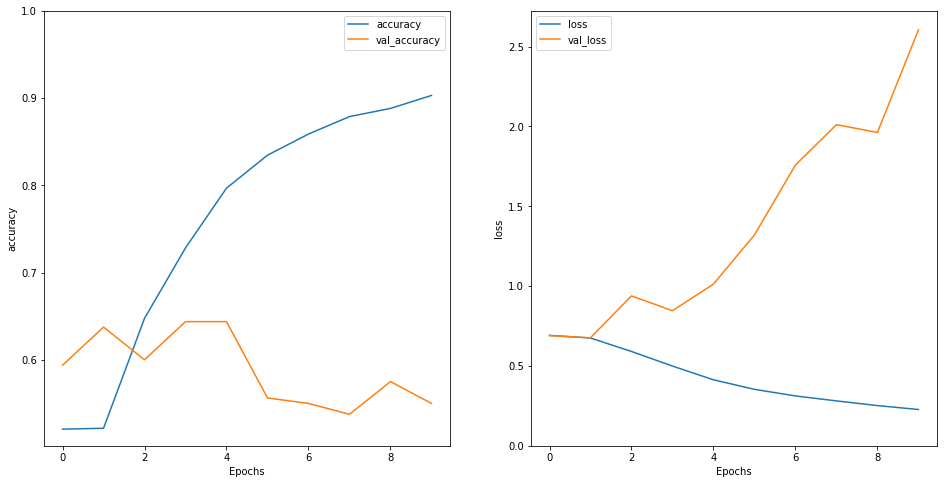

In [559]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

Run a prediction on a neew sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [560]:
# predict on a sample text without padding.

sample_text1 = ('White House, Congress Republicans nearing key tax overhaul decisions')
sample_text2 = ('Democrats Hope Sunday Obamacare Rallies Can Help Them Regain Momentum ')

predictions = model.predict(np.array([sample_text1, sample_text2]))
print(predictions)

[[ 4.434865]
 [-9.360585]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.ipynb)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [561]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [562]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [563]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
194/194 [==============================] - 9s 49ms/step - loss: 0.6921 - accuracy: 0.5205 - val_loss: 0.6903 - val_accuracy: 0.5417
Epoch 2/10
194/194 [==============================] - 5s 26ms/step - loss: 0.6821 - accuracy: 0.5205 - val_loss: 0.6724 - val_accuracy: 0.5312
Epoch 3/10
194/194 [==============================] - 4s 21ms/step - loss: 0.6010 - accuracy: 0.6288 - val_loss: 0.7859 - val_accuracy: 0.6167
Epoch 4/10
194/194 [==============================] - 4s 19ms/step - loss: 0.5087 - accuracy: 0.7176 - val_loss: 0.9723 - val_accuracy: 0.6146
Epoch 5/10
194/194 [==============================] - 4s 20ms/step - loss: 0.4245 - accuracy: 0.7900 - val_loss: 1.2881 - val_accuracy: 0.5562
Epoch 6/10
194/194 [==============================] - 4s 21ms/step - loss: 0.3566 - accuracy: 0.8394 - val_loss: 1.4176 - val_accuracy: 0.5833
Epoch 7/10
194/194 [==============================] - 5s 25ms/step - loss: 0.3097 - accuracy: 0.8759 - val_loss: 1.6140 - val_accuracy: 0.5896

In [564]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

44/44 [==============================] - 0s 7ms/step - loss: 1.8918 - accuracy: 0.6284
Test Loss: 1.8917521238327026
Test Accuracy: 0.6284469962120056


In [565]:
# predict on a sample text without padding.

sample_text1 = ('White House, Congress Republicans nearing key tax overhaul decisions')
sample_text2 = ('Democrats Hope Sunday Obamacare Rallies Can Help Them Regain Momentum ')

predictions = model.predict(np.array([sample_text1, sample_text2]))
print(predictions)

[[ 2.9392362]
 [-8.123318 ]]


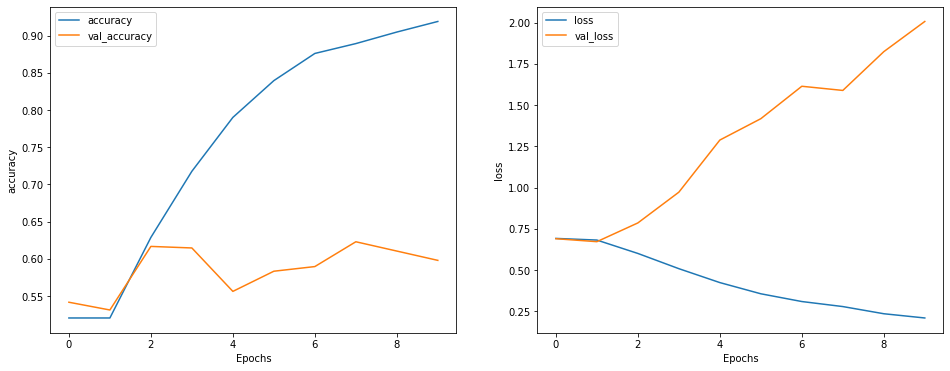

In [566]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')